In [1]:
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import soundfile as sf

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
CONTENT_FILENAME = "/content/drive/MyDrive/Colab Notebooks/data/inputs/imperial.mp3"
STYLE_FILENAME = "/content/drive/MyDrive/Colab Notebooks/data/inputs/usa.mp3"
OUTPUT_FILENAME = '/content/drive/MyDrive/Colab Notebooks/tf_outputs/latest_output_v2.wav'

In [3]:
N_FFT = 2048

def to_spec(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [4]:
a_content, fs = to_spec(CONTENT_FILENAME)
a_style, fs = to_spec(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_FREQS = a_content.shape[0]

a_style = a_style[:N_FREQS, :N_SAMPLES] # slicing

print("Style Shape:", a_style.shape)
print("Content Shape:", a_style.shape)

Style Shape: (1025, 430)
Content Shape: (1025, 430)


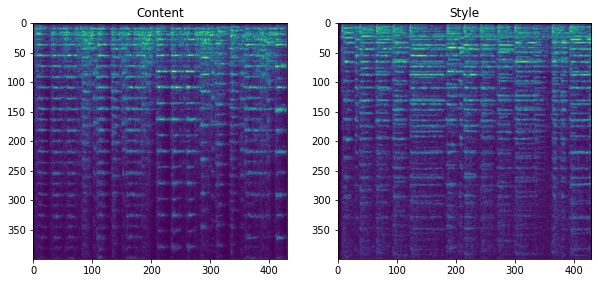

Content


Style


In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

print('Content')
display(Audio(CONTENT_FILENAME))
print('Style')
display(Audio(STYLE_FILENAME))

In [6]:
N_FILTERS = 4096

std = np.sqrt(2) * np.sqrt(2.0 / ((N_FREQS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_FREQS, N_FILTERS)*std
print('Filter Shape:\t', kernel.shape, '\t(HEIGHT, WIDTH, N_FREQS, N_FILTERS)')

a_content_tf = np.ascontiguousarray(a_content.T[None, None, : , :])
a_style_tf = np.ascontiguousarray(a_style.T[None, None, :, :])
print('Content Shape:\t', a_content_tf.shape, '\t(BATCH, CHANNELS, N_SAMPLES, N_FREQS)')
print('Style Shape:\t', a_style_tf.shape, '\t(BATCH, CHANNELS, N_SAMPLES, N_FREQS)')

Filter Shape:	 (1, 11, 1025, 4096) 	(HEIGHT, WIDTH, N_FREQS, N_FILTERS)
Content Shape:	 (1, 1, 430, 1025) 	(BATCH, CHANNELS, N_SAMPLES, N_FREQS)
Style Shape:	 (1, 1, 430, 1025) 	(BATCH, CHANNELS, N_SAMPLES, N_FREQS)


In [ ]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

ALPHA = 1
BETA = 10000
NUM_ITERATIONS = 100

# Caricamento delle immagini
def load_image(image_path):
    max_dim = 512
    img = PIL.Image.open(image_path)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), PIL.Image.ANTIALIAS)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img.reshape((1,) + img.shape)
    img = img - MEAN_VALUES
    return img

content_image = load_image(CONTENT_IMG_PATH)
style_image = load_image(STYLE_IMG_PATH)

# Modello VGG19
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Estrazione delle features
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """Prepara il modello VGG19 con le layer specificate"""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
    return model

def gram_matrix(input_tensor):
    """Calcola la matrice di Gram di un tensore"""
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    """Modello che restituisce le features di contenuto e stile"""
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        """Calcola le features di contenuto e stile"""
        # Scale back the pixel values
        inputs = inputs*255.0
        # Preprocess image with VGG mean
        preprocessed_input = inputs - MEAN_VALUES
        # Get outputs from the style and content layers
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])
        # Calculate the gram matrix for each style output
        style_features = [gram_matrix(style_output)
                          for style_output in style_outputs]
        # Calculate